In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")
import pandas as pd 
import numpy as np 

import torch
import torchvision
import torch.nn as nn
from torchvision.ops.misc import MLP, Conv2dNormActivation
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

from collections import OrderedDict
import math
from functools import partial
from typing import Any, Callable, Dict, List, NamedTuple, Optional

In [3]:
from src.processing import hrrr_data
from src.processing import nysm_data
from src.processing import get_error
from src.processing import normalize


def columns_drop(df):
    df = df.drop(
        columns=[
            "level_0",
            "index_x",
            "index_y",
            "lead time",
            "lsm",
            "station_y",
            "lat",
            "lon",
        ]
    )
    df = df.rename(columns={"station_x": "station"})
    return df


def create_data_for_model():
    """
    This function creates and processes data for a vision transformer machine learning model.

    Returns:
        df_train (pandas DataFrame): A DataFrame for training the machine learning model.
        df_test (pandas DataFrame): A DataFrame for testing the machine learning model.
        features (list): A list of feature names.
    """
    # load nysm data
    nysm_df = nysm_data.load_nysm_data()
    nysm_df.reset_index(inplace=True)
    nysm_df = nysm_df.rename(columns={"time_1H": "valid_time"})

    # load hrrr data
    hrrr_df = hrrr_data.read_hrrr_data()

    # Filter data by NY climate division
    nysm_cats_path = "/home/aevans/nwp_bias/src/landtype/data/nysm.csv"
    nysm_cats_df = pd.read_csv(nysm_cats_path)
    nysm_cats_df = nysm_cats_df[
        nysm_cats_df["climate_division_name"] == "Western Plateau"
    ]
    stations = nysm_cats_df["stid"].tolist()
    stations= stations[:2]
    nysm_df = nysm_df[nysm_df["station"].isin(stations)]
    hrrr_df = hrrr_df[hrrr_df["station"].isin(stations)]

    # need to create a master list for valid_times so that all the dataframes are the same shape
    master_time = hrrr_df['valid_time'].tolist()
    for station in stations:
        hrrr_dft = hrrr_df[hrrr_df["station"] == station]
        nysm_dft = nysm_df[nysm_df["station"] == station]
        times = hrrr_dft['valid_time'].tolist()
        times2 = nysm_dft['valid_time'].tolist()
        result = list(set(times) & set(master_time) & set(times2))
        master_time = result
    master_time_final = master_time

    # Filter NYSM data to match valid times from master-list
    nysm_df_filtered = nysm_df[nysm_df["valid_time"].isin(master_time_final)]
    hrrr_df_filtered = hrrr_df[hrrr_df["valid_time"].isin(master_time_final)]

    df_train_ls = []
    df_test_ls = []
    # merge dataframes so that each row is hrrr + nysm data for the same time step
    # do this for each station individually
    for station in stations:
        print(f'Compiling Data for {station}')
        nysm_df1 = nysm_df_filtered[nysm_df_filtered["station"] == station]
        hrrr_df1 = hrrr_df_filtered[hrrr_df_filtered["station"] == station]

        master_df = hrrr_df1.merge(nysm_df1, on="valid_time")
        master_df = columns_drop(master_df)

        # Calculate the error using NWP data.
        master_df = get_error.nwp_error("t2m", master_df)
        # encode for day_of_year
        master_df = normalize.encode(master_df, "day_of_year", 366)

        cols_to_carry = ["valid_time", "station", "latitude", "longitude"]

        new_df = master_df.drop(columns=cols_to_carry)

        new_df, features = normalize.normalize_df(new_df)
        new_df = new_df.fillna(0)

        # Split the data into training and testing sets.
        length = len(new_df)
        test_len = int(length * 0.8)
        df_train = new_df.iloc[:test_len].copy()
        df_test = new_df.iloc[test_len:].copy()
        print("Test Set Fraction", len(df_test) / len(new_df))

        # Reintegrate the specified columns back into the training and testing DataFrames.
        # for c in cols_to_carry:
        #     df_train[c] = master_df[c]
        #     df_test[c] = master_df[c]
        df_train_ls.append(df_train)
        df_test_ls.append(df_test)

        print("train_shape", df_train.shape)
        print("test_shape", df_test.shape)
        # print("train_start", df_train['valid_time'].iloc[0])
        # print("test_start", df_test['valid_time'].iloc[0])
    return df_train_ls, df_test_ls, features, stations


# Create Data for Vision Transformer
### We will target Western Plateau for consistency 

In [4]:
df_train_ls, df_test_ls, features, stations = create_data_for_model()

Compiling Data for ADDI
Test Set Fraction 0.20000487995315244
train_shape (32787, 34)
test_shape (8197, 34)
Compiling Data for BELM
Test Set Fraction 0.20000487995315244
train_shape (32787, 34)
test_shape (8197, 34)


In [5]:
df_train_ls[0].keys()

Index(['t2m', 'sh2', 'd2m', 'r2', 'u10', 'v10', 'tp', 'mslma', 'orog', 'tcc',
       'asnow', 'cape', 'dswrf', 'dlwrf', 'gh', 'u_total', 'u_dir', 'new_tp',
       'day_of_year_cos', 'day_of_year_sin', 'target_error', 'elev', 'tair',
       'ta9m', 'td', 'relh', 'srad', 'pres', 'mslp', 'wspd_sonic',
       'wmax_sonic', 'wdir_sonic', 'precip_total', 'snow_depth'],
      dtype='object')

In [6]:
class MultiStationDataset(Dataset):
    def __init__(self, dataframes, target, features, past_steps, future_steps, nysm_vars=12):
        """
        dataframes: list of station dataframes like in the SequenceDataset
        target: target error
        features: list of features for model
        sequence_length: int
        """
        self.dataframes = dataframes
        self.features = features
        self.target = target
        self.past_steps = past_steps
        self.future_steps = future_steps
        self.nysm_vars = nysm_vars

    def __len__(self):
        shaper = min([self.dataframes[i].values.shape[0] - (self.past_steps + self.future_steps) for i in range(len(self.dataframes))])
        return shaper

    def __getitem__(self, i):
        # this is the preceeding sequence_length timesteps
        x = torch.stack([torch.tensor(dataframe[self.features].values[i : (i + self.past_steps + self.future_steps)]) for dataframe in self.dataframes])
        # stacking the sequences from each dataframe along a new axis, so the output is of shape (batch, stations (len(self.dataframes)), past_steps, features)
        y = torch.stack([torch.tensor(dataframe[self.target].values[i + self.past_steps : i + self.past_steps + self.future_steps]) for dataframe in self.dataframes])
        # this is (batch, stations, future_steps)
        x[-self.future_steps:, :self.nysm_vars] = -999.0 # check that this is setting the right positions to this value
        return x, y

## Load Datasets

In [7]:
train_dataset = MultiStationDataset(df_train_ls, 'target_error', features, 8, 8)

In [8]:
test_dataset = MultiStationDataset(df_test_ls, 'target_error', features, 8, 8)

# Define Model 

In [9]:
import torch
import torchvision
from torchvision.ops.misc import MLP, Conv2dNormActivation
from collections import OrderedDict
import math
from functools import partial
from typing import Any, Callable, Dict, List, NamedTuple, Optional

import torch.nn as nn

class MLPBlock(MLP):
    """Transformer MLP block."""
    _version = 2

    def __init__(self, in_dim: int, mlp_dim: int, dropout: float):
        # Call the constructor of the parent class (MLP) with specific arguments
        super().__init__(in_dim, [mlp_dim, in_dim], activation_layer=nn.GELU, inplace=None, dropout=dropout)

        # Initialize the weights of linear layers using Xavier initialization
        # Initialize biases (if present) with a small value
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.normal_(m.bias, std=1e-6)

    def _load_from_state_dict(
        self,
        state_dict,
        prefix,
        local_metadata,
        strict,
        missing_keys,
        unexpected_keys,
        error_msgs,
    ):
        # Get the version metadata from the saved state_dict
        version = local_metadata.get("version", None)

        if version is None or version < 2:
            # If version is missing or less than 2, perform a modification to handle legacy state_dicts
            # Replace legacy MLPBlock keys with the new MLP keys (PyTorch Vision PR: https://github.com/pytorch/vision/pull/6053)
            for i in range(2):
                for type in ["weight", "bias"]:
                    old_key = f"{prefix}linear_{i+1}.{type}"
                    new_key = f"{prefix}{3*i}.{type}"
                    if old_key in state_dict:
                        # Replace the old key with the new key in the state_dict
                        state_dict[new_key] = state_dict.pop(old_key)

        # Call the parent class's _load_from_state_dict method
        super()._load_from_state_dict(
            state_dict,
            prefix,
            local_metadata,
            strict,
            missing_keys,
            unexpected_keys,
            error_msgs,
        )


class EncoderBlock(nn.Module):
    """Transformer encoder block."""

    def __init__(
        self,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.num_heads = num_heads

        # Attention block
        self.ln_1 = norm_layer(hidden_dim)
        self.self_attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=attention_dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

        # MLP block
        self.ln_2 = norm_layer(hidden_dim)
        self.mlp = MLPBlock(hidden_dim, mlp_dim, dropout)

    def forward(self, input: torch.Tensor):
        torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
        x = self.ln_1(input)
        x, _ = self.self_attention(x, x, x, need_weights=False)
        x = self.dropout(x)
        x = x + input

        y = self.ln_2(x)
        y = self.mlp(y)
        return x + y


class Encoder(nn.Module):
    """Transformer Model Encoder for sequence to sequence translation."""

    def __init__(
        self,
        seq_length: int,
        num_layers: int,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        # Note that batch_size is on the first dim because
        # we have batch_first=True in nn.MultiAttention() by default
        # self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, hidden_dim).normal_(std=0.02))  # from BERT
        self.dropout = nn.Dropout(dropout)
        layers: OrderedDict[str, nn.Module] = OrderedDict()
        for i in range(num_layers):
            layers[f"encoder_layer_{i}"] = EncoderBlock(
                num_heads,
                hidden_dim,
                mlp_dim,
                dropout,
                attention_dropout,
                norm_layer,
            )
        self.layers = nn.Sequential(layers)
        self.ln = norm_layer(hidden_dim)

    def forward(self, input: torch.Tensor):
        torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
        # input = input + self.pos_embedding
        return self.ln(self.layers(self.dropout(input)))


class VisionTransformer(nn.Module):
    """Vision Transformer as per https://arxiv.org/abs/2010.11929."""

    def __init__(
        self,
        stations: int,
        past_timesteps: int,
        future_timesteps: int,
        num_vars: int,
        num_layers: int,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        num_classes: int = 1,
        representation_size: Optional[int] = None,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.future_timesteps = future_timesteps
        self.past_timesteps = past_timesteps
        self.stations = stations
        self.timesteps = future_timesteps + past_timesteps
        self.hidden_dim = hidden_dim
        self.mlp_dim = mlp_dim
        self.attention_dropout = attention_dropout
        self.dropout = dropout
        self.num_classes = num_classes
        self.representation_size = representation_size
        self.norm_layer = norm_layer
        self.num_vars = num_vars

        self.mlp = torchvision.ops.MLP(num_vars, [hidden_dim], None, torch.nn.GELU, dropout=dropout)

        seq_length = stations * (future_timesteps + past_timesteps)

        # Add a class token
        self.class_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))
        seq_length += 1

        self.encoder = Encoder(
            seq_length,
            num_layers,
            num_heads,
            hidden_dim,
            mlp_dim,
            dropout,
            attention_dropout,
            norm_layer,
        )
        self.seq_length = seq_length

        heads_layers: OrderedDict[str, nn.Module] = OrderedDict()
        if representation_size is None:
            heads_layers["head"] = nn.Linear(hidden_dim, num_classes)
        else:
            heads_layers["pre_logits"] = nn.Linear(hidden_dim, representation_size)
            heads_layers["act"] = nn.Tanh()
            heads_layers["head"] = nn.Linear(representation_size, num_classes)

        self.heads = nn.Sequential(heads_layers)

        if hasattr(self.heads, "pre_logits") and isinstance(self.heads.pre_logits, nn.Linear):
            fan_in = self.heads.pre_logits.in_features
            nn.init.trunc_normal_(self.heads.pre_logits.weight, std=math.sqrt(1 / fan_in))
            nn.init.zeros_(self.heads.pre_logits.bias)

        if isinstance(self.heads.head, nn.Linear):
            nn.init.zeros_(self.heads.head.weight)
            nn.init.zeros_(self.heads.head.bias)

    def _process_input(self, x: torch.Tensor) -> torch.Tensor:
        # n = batch size
        # h = number of stations
        # w = number of time steps
        # c = number of features
        n, h, w, c = x.shape
        torch._assert(h == self.stations, f"Wrong image height! Expected {self.stations} but got {h}!")
        torch._assert(w == self.timesteps, f"Wrong image width! Expected {self.timesteps} but got {w}!")


        # (n, hidden_dim, n_h, n_w) -> (n, hidden_dim, (n_h * n_w))


        x = x.reshape(n, h * w, self.num_vars)
        x = self.mlp(x)

        return x

    def forward(self, x: torch.Tensor):
        # Reshape and permute the input tensor
        x = self._process_input(x)
        n = x.shape[0]

        # Expand the class token to the full batch
        batch_class_token = self.class_token.expand(n, -1, -1)
        x = torch.cat([batch_class_token, x], dim=1)


        x = self.encoder(x)

        # Classifier "token" is the future prediction - we will probably just want to select just some of these variables.
        # x \in (batch, stations * timesteps + 1, num_classes = 1)
        x = x[:, -(self.stations * self.future_timesteps):, :] # this shape is (batch, stations, num_classes = 1)

        x = self.heads(x) # is a linear transformation from hidden_dim to 1

        x = x.reshape(n, self.stations, self.future_timesteps, self.num_classes)
        
        return x.squeeze() # logically we are saying return one value for the each future timestep for each station (interpreted as error)


class AaronFormer(nn.Module):
    def __init__(self, 
                output_dim, 
                stations,
                past_timesteps,
                future_timesteps,  
                variables,            
                num_layers,
                num_heads,
                hidden_dim,
                mlp_dim,
                dropout, 
                attention_dropout,
                ):
        super().__init__()

        self.encoder = VisionTransformer(
                stations=stations,
                past_timesteps=past_timesteps,
                future_timesteps=future_timesteps,
                num_vars=variables,
                num_layers=num_layers,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                mlp_dim=mlp_dim,
                num_classes=output_dim,
                dropout=dropout,
                attention_dropout=attention_dropout
            )

    def forward(self, x):
        x = self.encoder(x)
        return x

# Define Model Parameters

In [10]:
model = AaronFormer(output_dim=1, 
stations = len(df_train_ls), 
past_timesteps=8,
future_timesteps=8,
variables=(len(df_train_ls[0].keys())-1),            
num_layers=12,
num_heads=12,
hidden_dim=768,
mlp_dim=3072,
dropout=0.0, 
attention_dropout=0.0,
)

In [11]:
EPOCHS = 3
BATCH_SIZE = 100
LEARNING_RATE = 2e-3

In [12]:
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# MSE Loss
loss_func = nn.MSELoss()
# Use GPU if available  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    model.cuda() 

In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 

In [14]:
def train_model(data_loader, model, loss_function, optimizer, device, epoch):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for batch_idx, (X, y) in enumerate(data_loader):
        X = X.to(torch.float32)
        y = y.to(torch.float32)
        # Move data and labels to the appropriate device (GPU/CPU).
        X, y = X.to(device), y.to(device)

        # Forward pass and loss computation.
        output = model(X)
        loss = loss_function(output, y)

        # Zero the gradients, backward pass, and optimization step.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the total loss and the number of processed samples.
        total_loss += loss.item()

    # Synchronize and aggregate losses in distributed training.
    # dist.all_reduce(ddp_loss, op=dist.ReduceOp.SUM)

    # Compute the average loss for the current epoch.
    avg_loss = total_loss / num_batches

    # Print the average loss on the master process (rank 0).
    print("epoch", epoch, "train_loss:", avg_loss)

    return avg_loss



def test_model(data_loader, model, loss_function, device, epoch):
    # Test a deep learning model on a given dataset and compute the test loss.

    num_batches = len(data_loader)
    total_loss = 0

    # Set the model in evaluation mode (no gradient computation).
    model.eval()

    for batch_idx, (X, y) in enumerate(data_loader):
        X = X.to(torch.float32)
        y = y.to(torch.float32)
        # Move data and labels to the appropriate device (GPU/CPU).
        X, y = X.to(device), y.to(device)
        # Forward pass to obtain model predictions.
        output = model(X)

        # Compute loss and add it to the total loss.
        total_loss += loss_function(output, y).item()

    # Calculate the average test loss.
    avg_loss = total_loss / num_batches
    print("epoch", epoch, "test_loss:", avg_loss)

    return avg_loss

In [17]:
for ix_epoch in range(1, EPOCHS + 1):
    print("Epoch", ix_epoch)
    train_loss = train_model(
        train_loader, model, loss_func, optimizer, device, ix_epoch
    )
    test_loss = test_model(test_loader, model, loss_func, device, ix_epoch)
    print()

Epoch 1
epoch 1 train_loss: 0.5552191041046526
epoch 1 test_loss: 0.6453205281641425

Epoch 2
epoch 2 train_loss: 0.5444704307833823
epoch 2 test_loss: 0.5890846764895974

Epoch 3
epoch 3 train_loss: 0.6025250505928587
epoch 3 test_loss: 0.6734511052689901



In [18]:
def predict(data_loader, model, device):
    output = torch.tensor([]).to(device)
    model.eval()
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(data_loader):
            X = X.to(torch.float32)
            X = X.to(device)
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    return output

In [19]:
prediction = predict(train_loader, model, device)

In [20]:
prediction = prediction.cpu()

In [21]:
prediction.shape

torch.Size([32771, 2, 8])

In [22]:
prediction[:,0,0]

tensor([-0.7047, -0.4087,  0.4282,  ..., -0.4785, -0.2922, -0.1382])

In [23]:
df_out = pd.DataFrame()
n = prediction.shape[1]
i = 0
while n>i:
    target = df_train_ls[i]['target_error']
    output = prediction[:,i,0]
    df_out[f'{i}_transformer_output'] = output
    df_out[f'{i}_target'] = target
    i+=1

In [24]:
df_out

,0_transformer_output,0_target,1_transformer_output,1_target
0,-0.704702,-0.879852,-0.704702,-0.394858
1,-0.408695,-1.050932,-0.408695,0.841306
2,0.428173,-1.201238,0.428173,0.064889
3,-0.750401,-1.390816,-0.750401,1.006482
4,-0.285610,-0.630492,-0.285610,0.994907
...,...,...,...,...
32766,-0.459743,-0.917425,-0.459743,-0.392949
32767,0.161096,-1.293234,0.161096,-0.611934
32768,-0.478450,-1.383733,-0.478450,-0.776859
32769,-0.292205,-0.900820,-0.292205,-0.228385


In [25]:
import statistics as st

for c in df_out.columns:
    vals = df_out[c].values.tolist()
    mean = st.mean(vals)
    std = st.pstdev(vals)
    df_out[c] = df_out[c] * std + mean

/tmp/tmp.gnc0EOpIsY/ipykernel_3413301/304268441.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[-1].set_xticklabels([2018, 2019, 2020, 2021, 2022], fontsize=18)


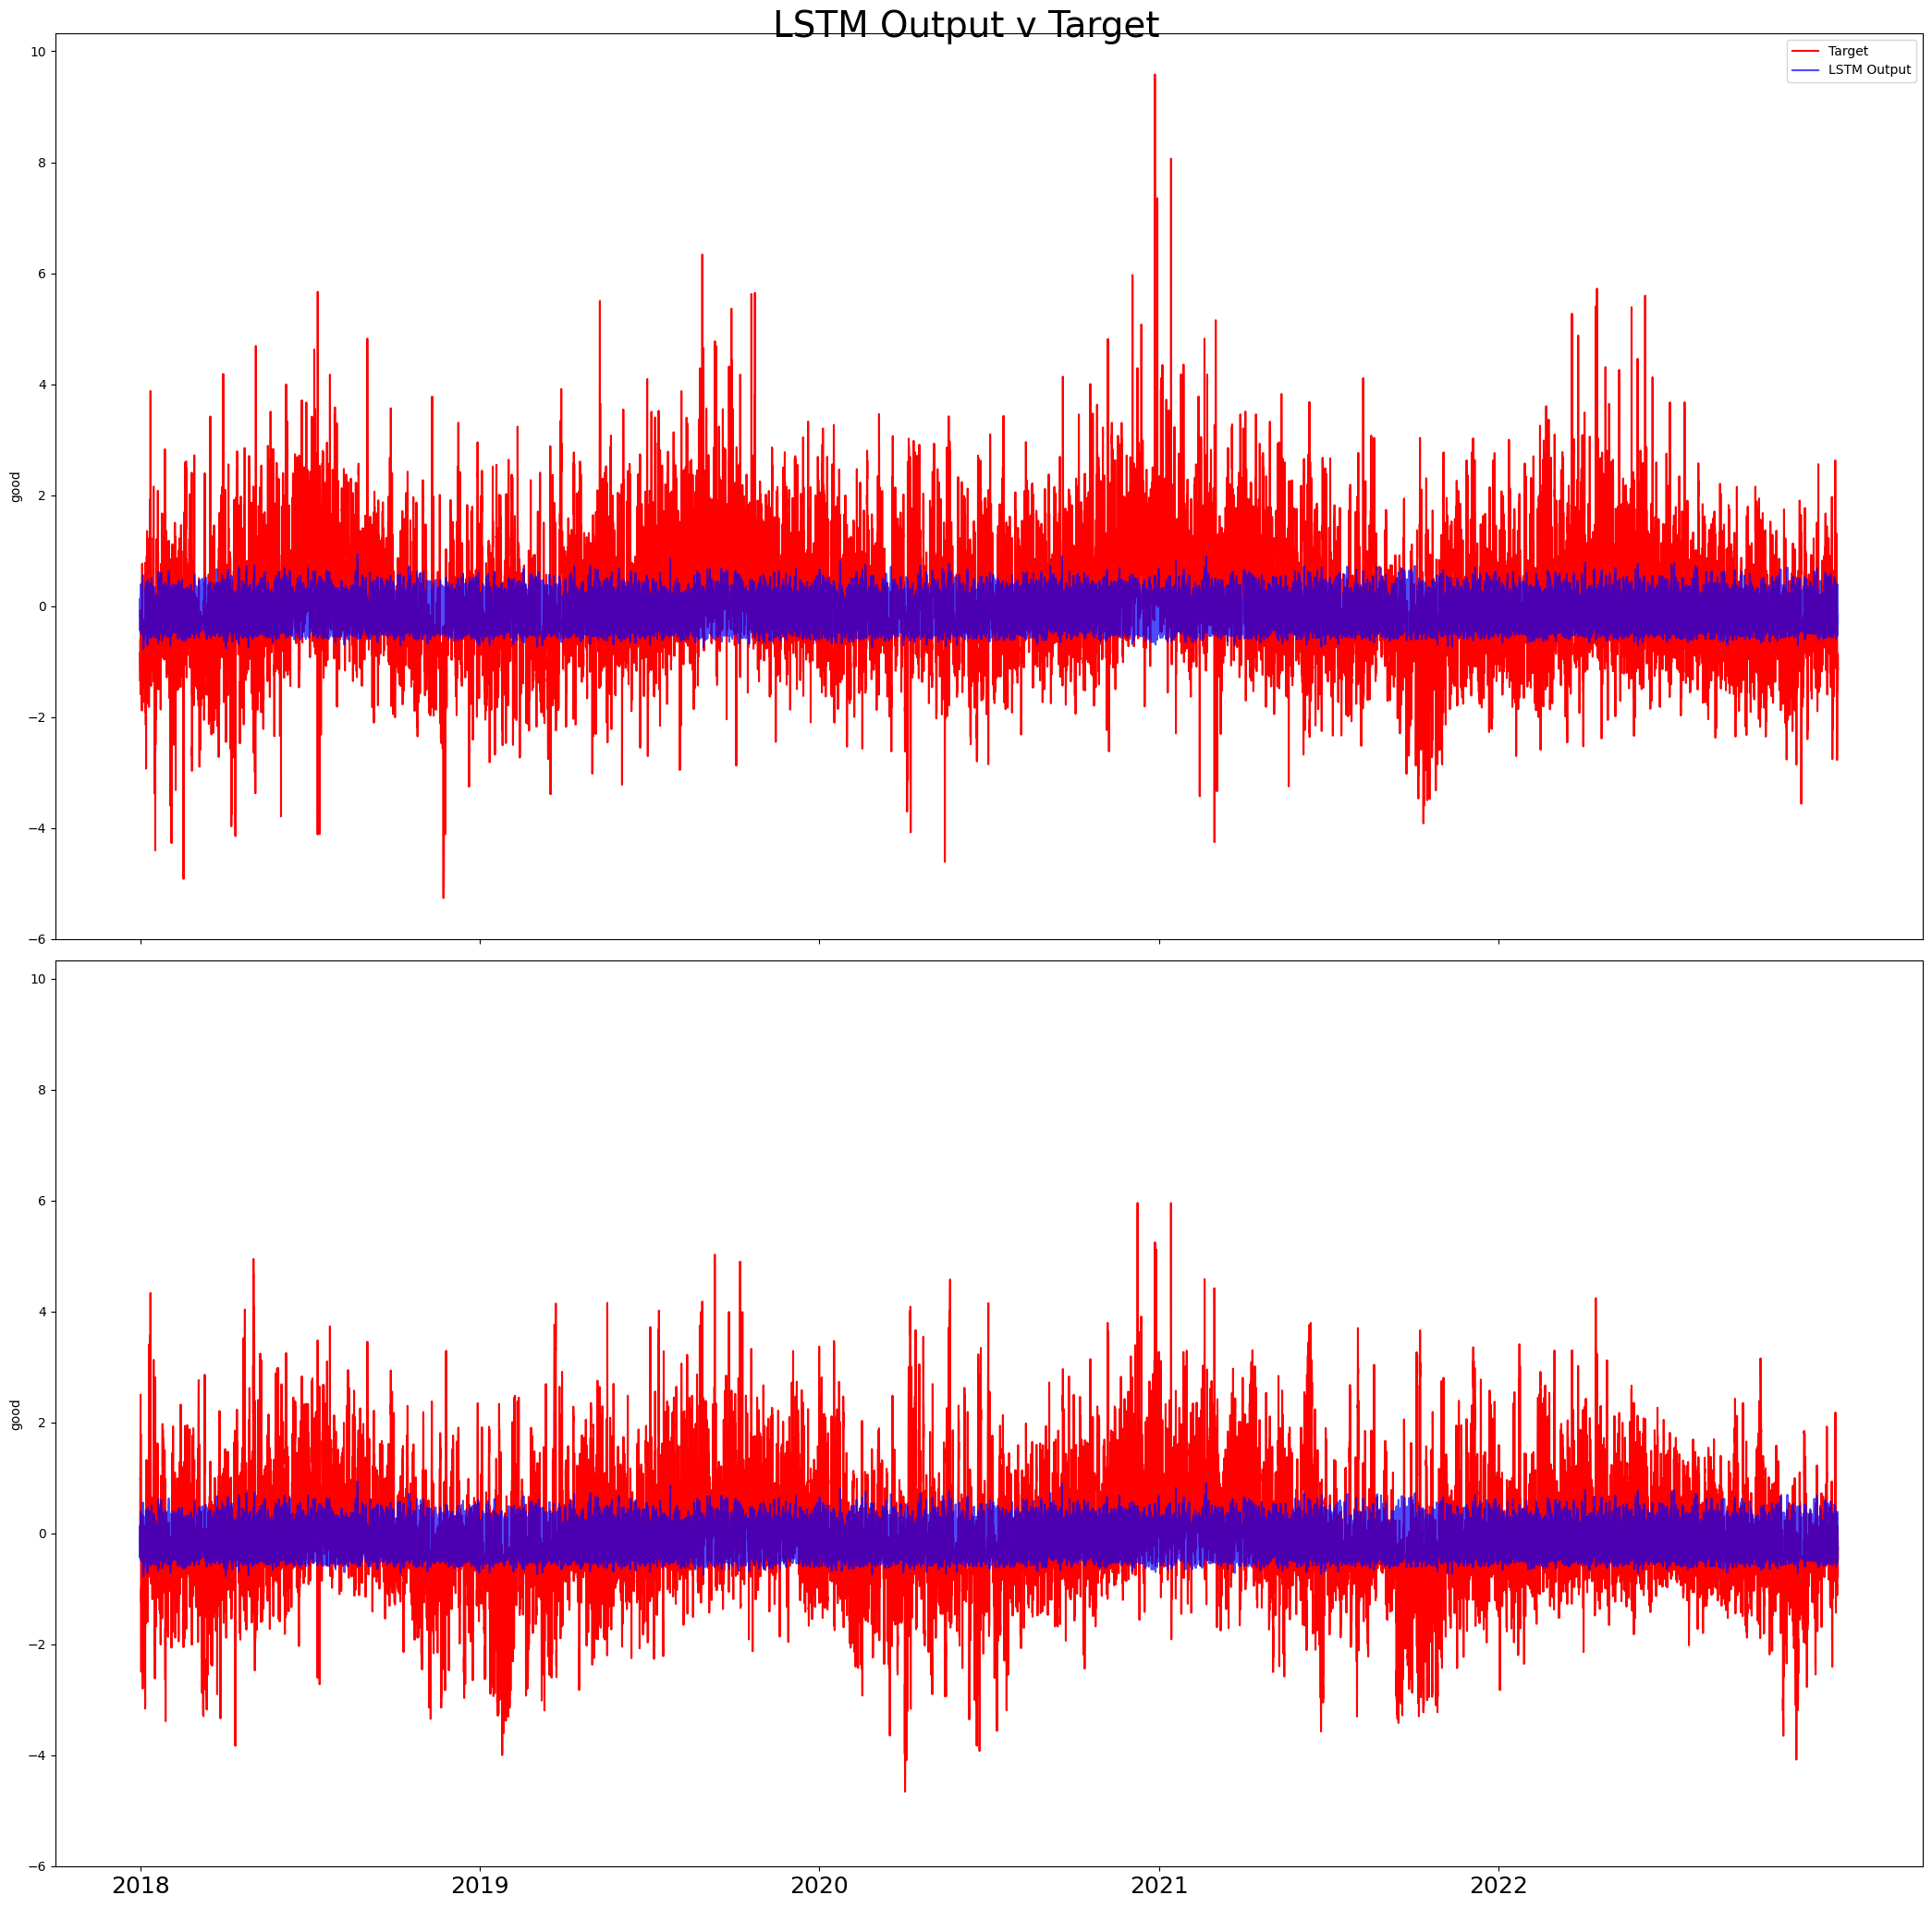

In [26]:
import matplotlib.pyplot as plt
df_out = df_out.sort_index()
fig, axs = plt.subplots(prediction.shape[1], figsize=(21, 21), sharex=True, sharey=True)
n = prediction.shape[1]
i = 0
while n>i:
    axs[i].set_ylabel('good')
    axs[i].plot(df_out[f'{i}_target'], c="r", label="Target")
    axs[i].plot(df_out[f"{i}_transformer_output"], c="b", alpha=0.7, label="LSTM Output")
    i+=1
fig.suptitle(f"LSTM Output v Target", fontsize=28)
axs[-1].set_xticklabels([2018, 2019, 2020, 2021, 2022], fontsize=18)
axs[-1].set_xticks(np.arange(0, len(df_out["0_target"]), len(df_out["0_target"]) / 5))
axs[0].legend()
plt.tight_layout()